In [1]:
# Different correlation analyses

from os import listdir
from scipy.stats import spearmanr, pearsonr
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.formula.api import ols
import statsmodels.api as sm
import operator
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from Support_Functions import *

C:\Users\gordillo\AppData\Local\Continuum\anaconda3\envs\stats_eeg\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\gordillo\AppData\Local\Continuum\anaconda3\envs\stats_eeg\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# option 1 - Pairwise Pearson (shown now in paper)
# option 2 - Pairwise Spearman
# option 3 - Dissatenuated Pearson
    # Here, since we do not have two measures of the same EEG feature, we use as an approximation of reliability
    # we use the largest correlation of feature A to B. Then, we use that correlation to estimate the dissatenuated values
    # assuming that correlations would be larger without noise using Rxy = rxy/sqrt(rxx ryy)
# option 4 - Dissatenuated Spearman (same as in 3)       
# option 5 - Correlate all variables from all features showing a significant difference between patients and controls  
# option 6 - Correlate principal components of each EEG feature 
# option 7 - Calculate dissatenuated correlation using 1st pcs as representative variable of each EEG feature 
    # same as in 3 et 4

# MULTIVARIATE 
# option 8 - Relative Inertias
# option 9 - "Dissatenuate" relative inertias
# option 10 - Distance correlations
# option 11 - "Dissatenuate" distance correlations

In [3]:
# Directory with data
DataDir = r""
# load data with the biggest difference in each feature
df_Big_Diff = pd.read_csv("Values_of_Biggest_Differences_ANCOVA.csv", index_col = 0)
# load CohensD, pvals and confidence interval from ANCOVAs
df_CohensD = pd.read_csv("CohenD_for_ANCOVAs.csv", index_col = 0)
# load file with full names of EEG features
df_EEG_names = pd.read_csv("eeg_features_names.csv", index_col = 0)

# Get the Group column, to find the Pat and Con, and then drop the column
Groups = df_Big_Diff['Group']
pat_ind = np.where(Groups == 'SZPatients')[0]
con_ind = np.where(Groups == 'Controls')[0]

df_Big_Diff = df_Big_Diff.drop('Group', axis = 1)
 
# significant p-values
sig_p_vals = np.where(df_CohensD['p-vals'] < 0.05)[0]

# Create a data frame with only the significant differences
df_Sig_Diff = df_Big_Diff[df_Big_Diff.columns[sig_p_vals]]
df_Sig_Diff_Pat = df_Sig_Diff.loc[pat_ind]
df_Sig_Diff_Con = df_Sig_Diff.loc[con_ind]

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, StandardScaler

data_ = PowerTransformer().fit_transform(df_Sig_Diff_Con.values)
pca_ = PCA(10)
pca_.fit(data_)
pca_.explained_variance_ratio_

C:\Users\gordillo\AppData\Local\Continuum\anaconda3\envs\stats_eeg\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


array([0.17955439, 0.12884777, 0.07003214, 0.06086056, 0.04893931,
       0.04223968, 0.04162368, 0.03701111, 0.03088411, 0.02871756])

In [6]:
# Option 1 (shown now in ms)
# create a correlation matrix of the data we want
corrMatrixPat = df_Sig_Diff_Pat.corr()
corrMatrixCon = df_Sig_Diff_Con.corr()
corrMatrixAll = df_Sig_Diff.corr()

n_feat=len(corrMatrixPat)

up_tri_ind = np.triu_indices(n_feat, k = 1)         # upper triangle indices

print("Using pearson correlation between the representative variables of each EEG feature")
print(f"|r| percentiles 25,50,75 controls: {np.percentile(np.abs(corrMatrixCon.values[up_tri_ind]),(25,50,75))}")
print(f"|r| percentiles 25,50,75 patients: {np.percentile(np.abs(corrMatrixPat.values[up_tri_ind]),(25,50,75))}")
print(f"|r| percentiles 25,50,75 patients: {np.percentile(np.abs(corrMatrixAll.values[up_tri_ind]),(25,50,75))}")

np.percentile(np.abs(corrMatrixCon['Microstates_Temp_Param']), (25, 50, 75))

Using pearson correlation between the representative variables of each EEG feature
|r| percentiles 25,50,75 controls: [0.05901676 0.1291479  0.24210832]
|r| percentiles 25,50,75 patients: [0.05536187 0.12217018 0.25083471]
|r| percentiles 25,50,75 patients: [0.0791335  0.15925338 0.28631667]


array([0.04970672, 0.08709182, 0.1495075 ])

In [5]:
# Save data from pearson analysis using variable showing the largest effect as the representative variable of the EEG feature
def calculate_pvalues(df):
    pvalues = np.zeros((len(df.columns),len(df.columns)))
    for r in range(len(df.columns)):
        for c in range(len(df.columns)):
            pvalues[r,c] = pearsonr(df[df.columns[r]], df[df.columns[c]])[1]
    return pvalues

p_valuesMatrixPat = calculate_pvalues(df_Sig_Diff_Pat)
p_valuesMatrixCon = calculate_pvalues(df_Sig_Diff_Con)

# save data for patients
# magnitudes
df_meta_1_patients = pd.DataFrame(data=corrMatrixPat,
                                  index=corrMatrixPat.columns,columns=corrMatrixPat.columns)
df_meta_1_patients.to_csv("meta_1_patients.csv")
# pvalues
df_meta_1_patients_pvalues = pd.DataFrame(data=p_valuesMatrixPat,
                                  index=corrMatrixPat.columns,columns=corrMatrixPat.columns)
df_meta_1_patients_pvalues.to_csv("meta_1_patients_pvalues.csv")

# save data for Controls
# magnitudes
df_meta_1_controls = pd.DataFrame(data=corrMatrixCon,
                                  index=corrMatrixCon.columns,columns=corrMatrixCon.columns)
df_meta_1_controls.to_csv("meta_1_controls.csv")
# pvalues
df_meta_1_controls_pvalues = pd.DataFrame(data=p_valuesMatrixCon,
                                  index=corrMatrixPat.columns,columns=corrMatrixPat.columns)
df_meta_1_controls_pvalues.to_csv("meta_1_controls_pvalues.csv")

In [6]:
# Option 2
pat_sp, pat_pval = spearmanr(df_Sig_Diff_Pat.values)
con_sp, con_pval = spearmanr(df_Sig_Diff_Con.values)
print("Using spearman correlation between the representative variables of each EEG feature")
print(f"|rho| percentiles 25,50,75 controls: {np.percentile(np.abs(con_sp[up_tri_ind]),(25,50,75))}")
print(f"|rho| percentiles 25,50,75 patients: {np.percentile(np.abs(pat_sp[up_tri_ind]),(25,50,75))}")

Using spearman correlation between the representative variables of each EEG feature
|rho| percentiles 25,50,75 controls: [0.06429587 0.13921152 0.23891181]
|rho| percentiles 25,50,75 patients: [0.05858631 0.13890733 0.26886273]


In [7]:
# Option 3
# Dissatenuated Pearson
con_data = np.abs(np.round(corrMatrixCon.values - np.eye(len(corrMatrixCon)),2))
pat_data = np.abs(np.round(corrMatrixPat.values - np.eye(len(corrMatrixPat)),2))

con_index = []
con_value = []

pat_index = []
pat_value = []

for k in range (len(con_data)):
    
    c_index, c_value = max(enumerate(con_data[k][np.where(con_data[k]<0.99)[0]]), key=operator.itemgetter(1))
    c_index = np.where(con_data[k]==c_value)[0][0]
    p_index, p_value = max(enumerate(pat_data[k][np.where(pat_data[k]<0.99)[0]]), key=operator.itemgetter(1))
    p_index = np.where(pat_data[k]==p_value)[0][0]
    
    con_index.append(c_index)
    con_value.append(c_value)
    
    pat_index.append(p_index)
    pat_value.append(p_value)

con_dis = np.zeros(con_data.shape)
pat_dis = np.zeros(pat_data.shape)

for k in range (len(con_data)):
    for j in range(len(con_data)):
        con_dis[k,j] = con_data[k,j]/np.sqrt(con_value[k]*con_value[j])
        pat_dis[k,j] = pat_data[k,j]/np.sqrt(pat_value[k]*pat_value[j])
    

up_tri_ind = np.triu_indices(len(con_dis), k = 1)  

con_dis[np.where(con_dis>1)] = 1
pat_dis[np.where(pat_dis>1)] = 1

print("Using disattenuated Pearson correlation between the representative variables of each EEG feature")
print(f"disattenuated |r| percentiles 25,50,75 controls: {np.percentile(np.abs(con_dis[up_tri_ind]),(25,50,75))}")
print(f"disattenuated |r| percentiles 25,50,75 patients: {np.percentile(np.abs(pat_dis[up_tri_ind]),(25,50,75))}")

Using disattenuated Pearson correlation between the representative variables of each EEG feature
disattenuated |r| percentiles 25,50,75 controls: [0.09148569 0.2079702  0.39197718]
disattenuated |r| percentiles 25,50,75 patients: [0.08382402 0.18762249 0.39549683]


In [8]:
# save disattenuated Pearson correlations
# magnitudes
df_meta_2_patients = pd.DataFrame(data=pat_dis + np.eye(len(pat_dis)),
                                  index=corrMatrixPat.columns,columns=corrMatrixPat.columns)
df_meta_2_patients.to_csv("meta_2_patients.csv")

# save data for Controls
# magnitudes
df_meta_2_controls = pd.DataFrame(data=con_dis + np.eye(len(con_dis)),
                                  index=corrMatrixCon.columns,columns=corrMatrixCon.columns)
df_meta_2_controls.to_csv("meta_2_controls.csv")

In [9]:
# features used as reference for reliability using Pearson correlation
# controls
con_eeg_feats = list(df_EEG_names.loc[corrMatrixCon.index]['new-names'])
con_max_corr = list(df_EEG_names.loc[corrMatrixCon.index[con_index]]['new-names'])
df_reliability_controls = pd.DataFrame(data=np.vstack((np.array(con_max_corr),np.array(con_value))).transpose(),
                              index=con_eeg_feats,columns=['used as reference', 'correlation'])

# save features selected for reliability analysis in controls
df_reliability_controls.to_csv("controls_estimate_reliability_pearson.csv")

# patients
pat_eeg_feats = list(df_EEG_names.loc[corrMatrixPat.index]['new-names'])
pat_max_corr = list(df_EEG_names.loc[corrMatrixPat.index[pat_index]]['new-names'])
df_reliability_patients = pd.DataFrame(data=np.vstack((np.array(pat_max_corr),np.array(pat_value))).transpose(),
                              index=pat_eeg_feats,columns=['used as reference', 'correlation'])

# save features selected for reliability analysis in patients
df_reliability_patients.to_csv("patients_estimate_reliability_pearson.csv")
df_reliability_patients

,used as reference,correlation
mod index alpha-gamma,mod index delta-gamma,0.62
mean ampl gamma,kfd gamma,0.91
mean ampl theta,kfd theta,0.97
std ampl gamma,kfd gamma,0.9
std ampl theta,mean ampl theta,0.8
...,...,...
spectral entropy gamma,kfd gamma,0.29
spectral entropy theta,hfd alpha,0.55
relative ampl theta,std ampl theta,0.73
waiting time beta,kurtosis ampl alpha,0.53


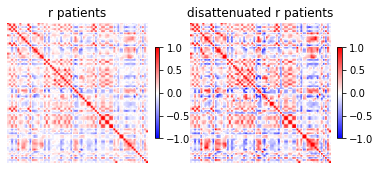

In [10]:
plt.subplot(1,2,1)
plt.title('r patients')
plt.imshow(corrMatrixPat,'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)
plt.subplot(1,2,2)
plt.title('disattenuated r patients')
plt.imshow(pat_dis*np.sign(corrMatrixPat)+np.eye(len(corrMatrixCon)),'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)

In [11]:
# Option 4
# Dissatenuated Spearman
con_data_sp = np.abs(np.round(con_sp - np.eye(len(con_sp)),2))
pat_data_sp = np.abs(np.round(pat_sp - np.eye(len(pat_sp)),2))

con_index_sp = []
con_value_sp = []

pat_index_sp = []
pat_value_sp = []

for k in range (len(con_data_sp)):
    
    c_index_sp, c_value_sp = max(enumerate(con_data_sp[k][np.where(con_data_sp[k]<0.99)[0]]), key=operator.itemgetter(1))
    c_index_sp = np.where(con_data_sp[k]==c_value_sp)[0][0]
    p_index_sp, p_value_sp = max(enumerate(pat_data_sp[k][np.where(pat_data_sp[k]<0.99)[0]]), key=operator.itemgetter(1))
    p_index_sp = np.where(pat_data_sp[k]==p_value_sp)[0][0]
    
    con_index_sp.append(c_index_sp)
    con_value_sp.append(c_value_sp)
    
    pat_index_sp.append(p_index_sp)
    pat_value_sp.append(p_value_sp)

con_dis_sp = np.zeros(con_data_sp.shape)
pat_dis_sp = np.zeros(pat_data_sp.shape)

for k in range (len(con_data_sp)):
    for j in range(len(con_data_sp)):
        con_dis_sp[k,j] = con_data_sp[k,j]/np.sqrt(con_value_sp[k]*con_value_sp[j])
        pat_dis_sp[k,j] = pat_data_sp[k,j]/np.sqrt(pat_value_sp[k]*pat_value_sp[j])
    

up_tri_ind = np.triu_indices(len(con_dis_sp), k = 1)     
print("Using disattenuated Spearman correlation between the representative variables of each EEG feature")
print(f"disattenuated |rho| percentiles 25,50,75 controls: {np.percentile(np.abs(con_dis_sp[up_tri_ind]),(25,50,75))}")
print(f"disattenuated |rho| percentiles 25,50,75 patients: {np.percentile(np.abs(pat_dis_sp[up_tri_ind]),(25,50,75))}")

Using disattenuated Spearman correlation between the representative variables of each EEG feature
disattenuated |rho| percentiles 25,50,75 controls: [0.10101525 0.22222222 0.39080692]
disattenuated |rho| percentiles 25,50,75 patients: [0.09138414 0.21536525 0.42139542]


In [12]:
# features used as reference for reliability using spearman correlation
# controls
con_eeg_feats_sp = list(df_EEG_names.loc[corrMatrixCon.index]['new-names'])
con_max_corr_sp = list(df_EEG_names.loc[corrMatrixCon.index[con_index_sp]]['new-names'])
df_reliability_controls_sp = pd.DataFrame(data=np.vstack((np.array(con_max_corr_sp),np.array(con_value_sp))).transpose(),
                                          index=con_eeg_feats_sp,columns=['used as reference', 'correlation rho'])

# save features selected for reliability analysis in controls
df_reliability_controls_sp.to_csv("controls_estimate_reliability_spearman.csv")

# patients
pat_eeg_feats_sp = list(df_EEG_names.loc[corrMatrixPat.index]['new-names'])
pat_max_corr_sp = list(df_EEG_names.loc[corrMatrixPat.index[pat_index_sp]]['new-names'])
df_reliability_patients_sp = pd.DataFrame(data=np.vstack((np.array(pat_max_corr_sp),np.array(pat_value_sp))).transpose(),
                                          index=pat_eeg_feats_sp,columns=['used as reference', 'correlation rho'])

# save features selected for reliability analysis in patients
df_reliability_patients_sp.to_csv("patients_estimate_reliability_spearman.csv")
df_reliability_patients_sp

,used as reference,correlation rho
mod index alpha-gamma,mod index delta-gamma,0.31
mean ampl gamma,node str s-lps gamma,0.66
mean ampl theta,std ampl theta,0.85
std ampl gamma,node str s-lps gamma,0.66
std ampl theta,mean ampl theta,0.85
...,...,...
spectral entropy gamma,life time gamma,0.36
spectral entropy theta,kfd theta,0.65
relative ampl theta,hfd alpha,0.66
waiting time beta,kurtosis ampl alpha,0.52


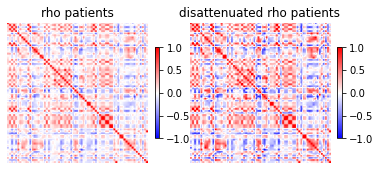

In [13]:
plt.subplot(1,2,1)
plt.title('rho patients')
plt.imshow(pat_sp,'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)
plt.subplot(1,2,2)
plt.title('disattenuated rho patients')
plt.imshow(pat_dis_sp*np.sign(pat_sp)+np.eye(len(pat_sp)),'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)

Using correlations all the variables of all EEG features
r percentiles 25,50,75 controls: [0.04978196 0.10773438 0.19865368]
r percentiles 25,50,75 patients: [0.04729147 0.10512388 0.20740225]
rho percentiles 25,50,75 controls: [0.05459459 0.11795164 0.21359886]
rho percentiles 25,50,75 patients: [0.05489094 0.12129793 0.2326785 ]


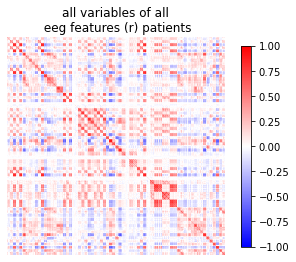

In [14]:
# Option 5 
# Show data from all variables of all EEG features showing a significant group difference between patients and controls
all_data_pat = []
all_data_con = []
eeg_features = corrMatrixCon.index
for k in range (len(eeg_features)):
    # read data
    dataX = pd.read_csv(DataDir + "\\" + eeg_features[k] + ".csv")
    DataEEG = dataX.values[:,1:].astype(float)
    ix_pat = np.where(dataX['Group']=='SZPatients')
    ix_con = np.where(dataX['Group']=='Controls')
    all_data_pat += [DataEEG[ix_pat,:][0]]
    all_data_con += [DataEEG[ix_con,:][0]]
    
# concatenate all data
eeg_patients = np.concatenate(all_data_pat,1)
pat_all_corr = np.corrcoef(eeg_patients.T)
pat_all_corr_sp = spearmanr(eeg_patients)[0]
eeg_controls = np.concatenate(all_data_con,1)
con_all_corr = np.corrcoef(eeg_controls.T)
con_all_corr_sp = spearmanr(eeg_controls)[0]

up_tri_ind = np.triu_indices(len(con_all_corr), k = 1)     

print("Using correlations all the variables of all EEG features")
print(f"r percentiles 25,50,75 controls: {np.percentile(np.abs(con_all_corr[up_tri_ind]),(25,50,75))}")
print(f"r percentiles 25,50,75 patients: {np.percentile(np.abs(pat_all_corr[up_tri_ind]),(25,50,75))}")
print(f"rho percentiles 25,50,75 controls: {np.percentile(np.abs(con_all_corr_sp[up_tri_ind]),(25,50,75))}")
print(f"rho percentiles 25,50,75 patients: {np.percentile(np.abs(pat_all_corr_sp[up_tri_ind]),(25,50,75))}")

plt.title('all variables of all\n eeg features (r) patients')
plt.imshow(pat_all_corr,'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)

(array([2671070., 2208103., 1571789., 1035079.,  689178.,  488030.,
         364374.,  282380.,  224441.,  173559.,  129480.,   90560.,
          60085.,   41650.,   32060.,   27054.,   23415.,   16097.,
           9130.,    3222.]),
 array([5.85633720e-09, 5.00000056e-02, 1.00000005e-01, 1.50000005e-01,
        2.00000005e-01, 2.50000004e-01, 3.00000004e-01, 3.50000004e-01,
        4.00000004e-01, 4.50000003e-01, 5.00000003e-01, 5.50000003e-01,
        6.00000002e-01, 6.50000002e-01, 7.00000002e-01, 7.50000001e-01,
        8.00000001e-01, 8.50000001e-01, 9.00000001e-01, 9.50000000e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

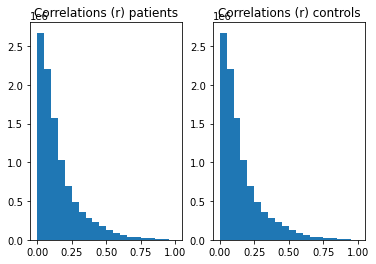

In [15]:
# All pairwise correlations between all variables of the EEG features showing a significant difference between patients and controls
plt.subplot(1,2,1)
plt.title('Correlations (r) patients')
plt.hist(np.abs(pat_all_corr[up_tri_ind]),20)
plt.subplot(1,2,2)
plt.title('Correlations (r) controls')
plt.hist(np.abs(pat_all_corr[up_tri_ind]),20)

In [12]:
# Option 6 correlate pairwise principal component of each EEG feature 

pc_pat = []
ev_pat = []

pc_con = []
ev_con = []

eeg_features = corrMatrixCon.index
for k in range (len(eeg_features)):
    # read data
    dataX = pd.read_csv(DataDir + "\\" + eeg_features[k] + ".csv")
    DataEEG = dataX.values[:,1:].astype(float)
    ix_pat = np.where(dataX['Group']=='SZPatients')
    ix_con = np.where(dataX['Group']=='Controls')
    
    # for patients
    pat_data = DataEEG[ix_pat,:][0]
    pat_data = StandardScaler().fit_transform(pat_data)
    
    pca_pat = PCA(n_components = 1)
    pat_data = pca_pat.fit_transform(pat_data)
    pc_pat.append(pat_data)
    ev_pat.append(pca_pat.explained_variance_ratio_)
    
    # for controls
    con_data = DataEEG[ix_con,:][0]
    con_data = StandardScaler().fit_transform(con_data)
    
    pca_con = PCA(n_components = 1)
    con_data = pca_con.fit_transform(con_data)
    pc_con.append(con_data)
    ev_con.append(pca_con.explained_variance_ratio_)

pc_pat = np.hstack(pc_pat)
pc_pat_corr = np.corrcoef(pc_pat.T)
pc_pat_corr_sp = spearmanr(pc_pat.T)[0]
pc_con = np.hstack(pc_con)
pc_con_corr = np.corrcoef(pc_con.T)
pc_con_corr_sp = spearmanr(pc_con.T)[0]

up_tri_ind = np.triu_indices(len(pc_con_corr), k = 1)    

print("Pearson correlations using the principal component of each EEG feature")
print(f"r percentiles 25,50,75 controls: {np.percentile(np.abs(pc_con_corr[up_tri_ind]),(25,50,75))}")
print(f"r percentiles 25,50,75 patients: {np.percentile(np.abs(pc_pat_corr[up_tri_ind]),(25,50,75))}")
print("Spearman correlations using the principal component of each EEG feature")
print(f"rho percentiles 25,50,75 controls: {np.percentile(np.abs(pc_con_corr_sp[up_tri_ind]),(25,50,75))}")
print(f"rho percentiles 25,50,75 patients: {np.percentile(np.abs(pc_pat_corr_sp[up_tri_ind]),(25,50,75))}")
print("Explained variances by 1st principal components")
print(f"25, 50, 75th percentiles of explained variances by 1st principal component in controls: {np.percentile(np.concatenate(ev_con),(25,50,75))}")
print(f"25, 50, 75th percentiles of explained variances by 1st principal component in patients: {np.percentile(np.concatenate(ev_pat),(25,50,75))}")

Pearson correlations using the principal component of each EEG feature
r percentiles 25,50,75 controls: [0.05944521 0.13469011 0.26412627]
r percentiles 25,50,75 patients: [0.0603904  0.15246186 0.31296726]
Spearman correlations using the principal component of each EEG feature
rho percentiles 25,50,75 controls: [0.09201681 0.20732554 0.35061198]
rho percentiles 25,50,75 patients: [0.11072342 0.23589697 0.38320241]
Explained variances by 1st principal components
25, 50, 75th percentiles of explained variances by 1st principal component in controls: [0.4131731  0.56588055 0.70671819]
25, 50, 75th percentiles of explained variances by 1st principal component in patients: [0.43805371 0.57479729 0.68085688]


In [13]:
# save data for meta correlation
pd_pc_pat = pd.DataFrame(data = pc_pat, columns = eeg_features)
pc_pat_corr = pd_pc_pat.corr()
pd_pc_con = pd.DataFrame(data = pc_con, columns = eeg_features)
pc_con_corr = pd_pc_con.corr()

# calculate p-values of correlations
p_valuesMatrixPat_pc = calculate_pvalues(pd_pc_pat)
p_valuesMatrixCon_pc = calculate_pvalues(pd_pc_con)

# save data for patients
# magnitudes
df_meta_3_patients = pd.DataFrame(data=pc_pat_corr,
                                  index=pc_pat_corr.columns,columns=pc_pat_corr.columns)
df_meta_3_patients.to_csv("meta_3_patients.csv")
# pvalues
df_meta_3_patients_pvalues = pd.DataFrame(data=p_valuesMatrixPat_pc,
                                          index=pc_pat_corr.columns,columns=pc_pat_corr.columns)
df_meta_3_patients_pvalues.to_csv("meta_3_patients_pvalues.csv")

# save data for Controls
# magnitudes
df_meta_3_controls = pd.DataFrame(data=pc_con_corr,
                                  index=pc_con_corr.columns,columns=pc_con_corr.columns)
df_meta_3_controls.to_csv("meta_3_controls.csv")
# pvalues
df_meta_3_controls_pvalues = pd.DataFrame(data=p_valuesMatrixCon_pc,
                                          index=pc_con_corr.columns,columns=pc_con_corr.columns)
df_meta_3_controls_pvalues.to_csv("meta_3_controls_pvalues.csv")

(array([ 3.,  2.,  7.,  4., 10.,  6.,  8., 13., 10.,  6.]),
 array([0.06111319, 0.14240066, 0.22368813, 0.3049756 , 0.38626306,
        0.46755053, 0.548838  , 0.63012546, 0.71141293, 0.7927004 ,
        0.87398786]),
 <BarContainer object of 10 artists>)

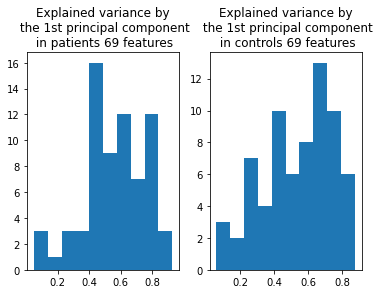

In [18]:
plt.subplot(1,2,1)
plt.title('Explained variance by\n the 1st principal component\n in patients 69 features')
plt.hist(np.concatenate(ev_pat),10)
plt.subplot(1,2,2)
plt.title('Explained variance by\n the 1st principal component\n in controls 69 features')
plt.hist(np.concatenate(ev_con),10)

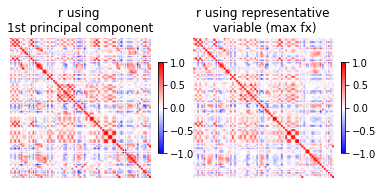

In [19]:
plt.subplot(1,2,1)
plt.title('r using \n1st principal component')
plt.imshow(np.corrcoef(pc_pat.T),'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)
plt.subplot(1,2,2)
plt.title('r using representative\n variable (max fx)')
plt.imshow(corrMatrixPat,'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)

In [14]:
# Option 7
# Dissatenuated Pearson using 1st principal component as the representative variable of each EEG feature
con_data_pc = np.abs(np.round(pc_con_corr.values - np.eye(len(pc_con_corr)),2))
pat_data_pc = np.abs(np.round(pc_pat_corr.values - np.eye(len(pc_pat_corr)),2))

con_index_pc = []
con_value_pc = []

pat_index_pc = []
pat_value_pc = []

for k in range (len(con_data_pc)):
    
    c_index_pc, c_value_pc = max(enumerate(con_data_pc[k][np.where(con_data_pc[k]<0.99)[0]]), key=operator.itemgetter(1))
    c_index_pc = np.where(con_data_pc[k]==c_value_pc)[0][0]
    p_index_pc, p_value_pc = max(enumerate(pat_data_pc[k][np.where(pat_data_pc[k]<0.99)[0]]), key=operator.itemgetter(1))
    p_index_pc = np.where(pat_data_pc[k]==p_value_pc)[0][0]
    
    con_index_pc.append(c_index_pc)
    con_value_pc.append(c_value_pc)
    
    pat_index_pc.append(p_index_pc)
    pat_value_pc.append(p_value_pc)

con_dis_pc = np.zeros(con_data_pc.shape)
pat_dis_pc = np.zeros(pat_data_pc.shape)

for k in range (len(con_data_pc)):
    for j in range(len(con_data_pc)):
        con_dis_pc[k,j] = con_data_pc[k,j]/np.sqrt(con_value_pc[k]*con_value_pc[j])
        pat_dis_pc[k,j] = pat_data_pc[k,j]/np.sqrt(pat_value_pc[k]*pat_value_pc[j])
    

up_tri_ind = np.triu_indices(len(con_dis_pc), k = 1)  

con_dis_pc[np.where(con_dis_pc>1)] = 1
pat_dis_pc[np.where(pat_dis_pc>1)] = 1

print("Using disattenuated Pearson using 1st principal component as the representative variable of each EEG feature")
print(f"disattenuated |r| percentiles 25,50,75 controls: {np.percentile(np.abs(con_dis_pc[up_tri_ind]),(25,50,75))}")
print(f"disattenuated |r| percentiles 25,50,75 patients: {np.percentile(np.abs(pat_dis_pc[up_tri_ind]),(25,50,75))}")

Using disattenuated Pearson using 1st principal component as the representative variable of each EEG feature
disattenuated |r| percentiles 25,50,75 controls: [0.08539126 0.2041493  0.39433078]
disattenuated |r| percentiles 25,50,75 patients: [0.08815673 0.20820223 0.43055593]


In [15]:
# save data for meta corr
# disattenuated Pearson correlations using 1st PC as representative variable for the analysis
# magnitudes
df_meta_4_patients = pd.DataFrame(data=pat_dis_pc + np.eye(len(pat_dis_pc)),
                                  index=pc_pat_corr.columns,columns=pc_pat_corr.columns)
df_meta_4_patients.to_csv("meta_4_patients.csv")

# save data for Controls
# magnitudes
df_meta_4_controls = pd.DataFrame(data=con_dis_pc + np.eye(len(con_dis_pc)),
                                  index=pc_con_corr.columns,columns=pc_con_corr.columns)
df_meta_4_controls.to_csv("meta_4_controls.csv")


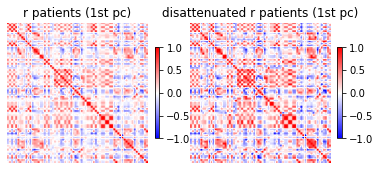

In [22]:
plt.subplot(1,2,1)
plt.title('r patients (1st pc)')
plt.imshow(pc_pat_corr,'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)
plt.subplot(1,2,2)
plt.title('disattenuated r patients (1st pc)')
plt.imshow(pat_dis_pc*np.sign(pc_pat_corr)+np.eye(len(pc_pat_corr)),'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)

In [18]:
# features used as reference for reliability using spearman correlation
# controls
con_eeg_feats_pc = list(df_EEG_names.loc[corrMatrixCon.index]['new-names'])
con_max_corr_pc = list(df_EEG_names.loc[corrMatrixCon.index[con_index_pc]]['new-names'])
df_reliability_controls_pc = pd.DataFrame(data=np.vstack((np.array(con_max_corr_pc),np.array(con_value_pc))).transpose(),
                                          index=con_eeg_feats_pc,columns=['used as reference', 'correlation r'])

# save features selected for reliability analysis in controls
df_reliability_controls_pc.to_csv("controls_estimate_reliability_pearson_pc.csv")

# patients
pat_eeg_feats_pc = list(df_EEG_names.loc[corrMatrixPat.index]['new-names'])
pat_max_corr_pc = list(df_EEG_names.loc[corrMatrixPat.index[pat_index_pc]]['new-names'])
df_reliability_patients_pc = pd.DataFrame(data=np.vstack((np.array(pat_max_corr_pc),np.array(pat_value_pc))).transpose(),
                                          index=pat_eeg_feats_pc,columns=['used as reference', 'correlation r'])

# save features selected for reliability analysis in patients
df_reliability_patients_pc.to_csv("patients_estimate_reliability_pearson_pc.csv")
df_reliability_patients_pc

,used as reference,correlation r
mod index alpha-gamma,kfd theta,0.57
mean ampl gamma,kfd gamma,0.95
mean ampl theta,kfd theta,0.97
std ampl gamma,kfd gamma,0.94
std ampl theta,kfd theta,0.97
...,...,...
spectral entropy gamma,node str e-plv gamma,0.49
spectral entropy theta,skewness ampl theta,0.72
relative ampl theta,mean ampl theta,0.74
waiting time beta,life time beta,0.85


(0.0, 300.0)

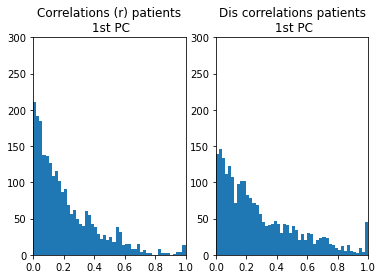

In [24]:
plt.subplot(1,2,1)
plt.title('Correlations (r) patients\n 1st PC')
plt.hist(np.abs(pc_pat_corr.values[up_tri_ind]),50)
plt.xlim(0, 1)
plt.ylim(0, 300)
plt.subplot(1,2,2)
plt.title('Dis correlations patients\n 1st PC')
plt.hist(np.abs(pat_dis_pc[up_tri_ind]),50)
plt.xlim(0, 1)
plt.ylim(0, 300)

In [25]:
# Option 8 
# Correlate pairwise kernel principal component of each EEG feature 

kpc_pat = []

kpc_con = []

eeg_features = corrMatrixCon.index

for k in range (len(eeg_features)):
    # read data
    dataX = pd.read_csv(DataDir + "\\" + eeg_features[k] + ".csv")
    DataEEG = dataX.values[:,1:].astype(float)
    ix_pat = np.where(dataX['Group']=='SZPatients')
    ix_con = np.where(dataX['Group']=='Controls')
    
    # for patients
    pat_data = DataEEG[ix_pat,:][0]
    pat_data = StandardScaler().fit_transform(pat_data)
    
    kpca_pat = KernelPCA(n_components = 1, kernel='rbf')
    pat_data = kpca_pat.fit_transform(pat_data)
    kpc_pat.append(pat_data)
    
    # for controls
    con_data = DataEEG[ix_con,:][0]
    con_data = StandardScaler().fit_transform(con_data)
    
    kpca_con = KernelPCA(n_components = 1,kernel='rbf')
    con_data = kpca_con.fit_transform(con_data)
    kpc_con.append(con_data)

In [26]:
kpc_pat = np.hstack(kpc_pat)
kpc_pat_corr = np.corrcoef(kpc_pat.T)
kpc_pat_corr_sp = spearmanr(kpc_pat.T)[0]
kpc_con = np.hstack(kpc_con)
kpc_con_corr = np.corrcoef(kpc_con.T)
kpc_con_corr_sp = spearmanr(kpc_con.T)[0]

up_tri_ind = np.triu_indices(len(kpc_con_corr), k = 1)    

print("Pearson correlations using the principal component using KPCA of each EEG feature")
print(f"r percentiles 25,50,75 controls: {np.percentile(np.abs(kpc_con_corr[up_tri_ind]),(25,50,75))}")
print(f"r percentiles 25,50,75 patients: {np.percentile(np.abs(kpc_pat_corr[up_tri_ind]),(25,50,75))}")
print("Spearman correlations using the principal component of each EEG feature")
print(f"rho percentiles 25,50,75 controls: {np.percentile(np.abs(kpc_con_corr_sp[up_tri_ind]),(25,50,75))}")
print(f"rho percentiles 25,50,75 patients: {np.percentile(np.abs(kpc_pat_corr_sp[up_tri_ind]),(25,50,75))}")

Pearson correlations using the principal component using KPCA of each EEG feature
r percentiles 25,50,75 controls: [0.07170477 0.15110746 0.26952273]
r percentiles 25,50,75 patients: [0.07486934 0.16894094 0.31180884]
Spearman correlations using the principal component of each EEG feature
rho percentiles 25,50,75 controls: [0.09554256 0.20398246 0.34790829]
rho percentiles 25,50,75 patients: [0.10141578 0.2230179  0.37078005]


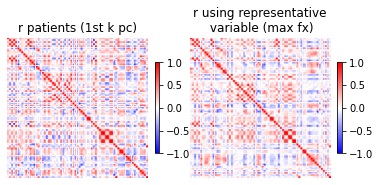

In [27]:
plt.subplot(1,2,1)
plt.title('r patients (1st k pc)')
plt.imshow(kpc_pat_corr,'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)
plt.subplot(1,2,2)
plt.title('r using representative\n variable (max fx)')
plt.imshow(corrMatrixPat,'bwr')
plt.axis('off')
plt.clim(-1,1)
plt.colorbar(fraction = 0.03)

Using distance correlation between the representative variables of each EEG feature
dc percentiles 25,50,75 controls: [0.18477662 0.22307936 0.29434498]
dc percentiles 25,50,75 patients: [0.15105193 0.19074637 0.28878602]


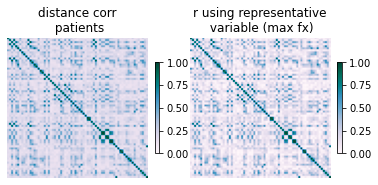

In [28]:
# Option 9 
# Use univariate distance correlations between the representative EEG features and all variables of the EEG features
# showing a significant difference between patients and controls 
univ_dc_Pat = df_Sig_Diff_Pat.values
univ_dc_Con = df_Sig_Diff_Con.values
i = 1
j = 1
dc_univ_pat = np.zeros((univ_dc_Pat.shape[1],univ_dc_Pat.shape[1]))
dc_univ_con = np.zeros((univ_dc_Con.shape[1],univ_dc_Con.shape[1]))
for i in range(univ_dc_Pat.shape[1]):
    for j in range(univ_dc_Pat.shape[1]):
        dc_univ_pat[i,j] = pg.distance_corr(univ_dc_Pat[:,i],univ_dc_Pat[:,j],n_boot=None)
        dc_univ_con[i,j] = pg.distance_corr(univ_dc_Con[:,i],univ_dc_Con[:,j],n_boot=None)

up_tri_ind = np.triu_indices(len(dc_univ_pat), k = 1)           
print("Using distance correlation between the representative variables of each EEG feature")
print(f"dc percentiles 25,50,75 controls: {np.percentile(np.abs(dc_univ_con[up_tri_ind]),(25,50,75))}")
print(f"dc percentiles 25,50,75 patients: {np.percentile(np.abs(dc_univ_pat[up_tri_ind]),(25,50,75))}")
plt.subplot(1,2,1)
plt.title('distance corr\n patients')
plt.imshow(dc_univ_pat,'PuBuGn')
plt.axis('off')
plt.clim(0,1)
plt.colorbar(fraction = 0.03)
plt.subplot(1,2,2)
plt.title('r using representative\n variable (max fx)')
plt.imshow(np.abs(corrMatrixPat),'PuBuGn')
plt.axis('off')
plt.clim(0,1)
plt.colorbar(fraction = 0.03)

In [29]:
# Option 10
# takes too long




# Show data from all variables of all EEG features showing a significant group difference between patients and controls
all_data_pat = []
all_data_con = []
eeg_features = corrMatrixCon.index
for k in range (len(eeg_features)):
    # read data
    dataX = pd.read_csv(DataDir + "\\" + eeg_features[k] + ".csv")
    DataEEG = dataX.values[:,1:].astype(float)
    ix_pat = np.where(dataX['Group']=='SZPatients')
    ix_con = np.where(dataX['Group']=='Controls')
    all_data_pat += [DataEEG[ix_pat,:][0]]
    all_data_con += [DataEEG[ix_con,:][0]]
    
# concatenate all data
eeg_patients = np.concatenate(all_data_pat,1)
eeg_controls = np.concatenate(all_data_con,1)

# correlate all variables of all EEG features showing a significant group difference using distance correlations
dc_univ_pat_all = np.zeros((eeg_patients.shape[1],eeg_patients.shape[1]))
dc_univ_con_all = np.zeros((eeg_controls.shape[1],eeg_controls.shape[1]))

for i in range(eeg_patients.shape[1]):
    for j in range(eeg_patients.shape[1]):
        dc_univ_pat_all[i,j] = pg.distance_corr(eeg_patients[:,i],eeg_patients[:,j],n_boot=None)
        dc_univ_con_all[i,j] = pg.distance_corr(eeg_controls[:,i],eeg_controls[:,j],n_boot=None)
        
up_tri_ind = np.triu_indices(len(dc_univ_pat_all), k = 1)           
print("Using distance correlation between the representative variables of each EEG feature all variables all features")
print(f"dc percentiles 25,50,75 controls: {np.percentile(np.abs(dc_univ_con_all[up_tri_ind]),(25,50,75))}")
print(f"dc percentiles 25,50,75 patients: {np.percentile(np.abs(dc_univ_pat_all[up_tri_ind]),(25,50,75))}")

plt.subplot(1,2,1)
plt.title('all variables of all\n eeg features (r) patients')
plt.imshow(np.abs(pat_all_corr),'PuBuGn')
plt.axis('off')
plt.clim(0,1)
plt.colorbar(fraction = 0.03)
plt.subplot(1,2,2)
plt.title('all variables of all\n eeg features (dc) patients')
plt.imshow(dc_univ_pat_all,'PuBuGn')
plt.axis('off')
plt.clim(0,1)
plt.colorbar(fraction = 0.03)

KeyboardInterrupt: 

### MULTIVARIATE ANALYSES

In [40]:
# Partial least squares correlation analysis
# fix seed for randomization
from random import sample, seed
import time

seed(5)
# function to calculate the inertias and do permutation (used for the ms)
def perm_PLSC(inFile1, inFile2, DataPath, which_grp):
    """function to do the PLSC and permutation
    inFile1 is the name of file 1
    inFile2 is the name of file 2
    DataPath is the path of the data
    which_group is the group we want to analyze (All, Pat, or Con)"""
    
    # read data
    dataX = pd.read_csv(DataPath + "\\" + inFile1)
    dataY = pd.read_csv(DataPath + "\\" + inFile2)

    # groups
    Group = dataX['Group']
    pat_ind = np.where(Group == 'SZPatients')[0]
    con_ind = np.where(Group == 'Controls')[0]

    if which_grp == 'All':
        # remove the first column which is just the group
        X = dataX.values[:,1:].astype(float)
        Y = dataY.values[:,1:].astype(float)
    elif which_grp == 'Pat':
        # remove the first column which is just the group
        X = dataX.values[pat_ind,1:].astype(float)
        Y = dataY.values[pat_ind,1:].astype(float)
    elif which_grp == 'Con':
        # remove the first column which is just the group
        X = dataX.values[con_ind,1:].astype(float)
        Y = dataY.values[con_ind,1:].astype(float)

    # normalize: subtract mean and divide by norm
    ZX = (X - X.mean(axis = 0)) # for X
    ZX /= np.linalg.norm(ZX, axis = 0)

    ZY = (Y - Y.mean(axis = 0)) # for Y
    ZY /= np.linalg.norm(ZY, axis = 0)


    # Get Matrix of correlations
    R = np.dot(ZY.transpose(),ZX)

    # single value decomposition
    U, s, Vh = np.linalg.svd(R, full_matrices=False)

    # Inertia
    Iner = s.sum()
    
    # for normalization
    norm_term=np.sqrt(R.shape[0]*R.shape[1])

    # stats permutation
    # originally 10000
    #n_perm = 10000
    n_perm = 10
    permIner = []
    indeces = range(X.shape[0])

    for i in range(n_perm):
        ind = sample(indeces, X.shape[0])
        ZXtmp = ZX[ind,:]
        
        # for permutation
        Rperm = np.dot(ZY.transpose(),ZXtmp)
        Uperm, sperm, Vhperm = np.linalg.svd(Rperm, full_matrices=False)
        permIner.append(sperm.sum())

        
    # the p-value
    pval = np.sum(permIner > Iner)/n_perm
    # relative inertias
    rel_in=Iner/norm_term
    
    return pval, Iner, rel_in, norm_term

In [ ]:
# PLSC analysis
# Get the name of the files that end with .csv in Results
# which are name of the files with the features
AllFile_names = list(filter(lambda x: '.csv' in x, listdir(DataDir)))

# Get only files that have sig differences
File_names = [AllFile_names[i] for i in sig_p_vals]

n_feat = len(sig_p_vals) # number of features
C_p_values = np.zeros((n_feat, n_feat))
C_Inertia = np.zeros((n_feat, n_feat))    # get some memory to store values
C_Relative_inertias = np.zeros((n_feat, n_feat))
C_Norm_term = np.zeros((n_feat, n_feat)) 

P_p_values = np.zeros((n_feat, n_feat))
P_Inertia = np.zeros((n_feat, n_feat))    # get some memory to store values
P_Relative_inertias = np.zeros((n_feat, n_feat))
P_Norm_term = np.zeros((n_feat, n_feat)) 

# fix seed for randomization
seed(5)

# upper triangle to loop
for i, j in list(zip(*np.triu_indices(n_feat))):
    start = time.time() # check how long it takes
    C_p_values[i,j], C_Inertia[i,j],C_Relative_inertias[i,j],\
        C_Norm_term[i,j] = perm_PLSC(File_names[i], File_names[j], DataDir, 'Con')
    
    P_p_values[i,j], P_Inertia[i,j],P_Relative_inertias[i,j],\
        P_Norm_term[i,j] = perm_PLSC(File_names[i], File_names[j], DataDir, 'Pat')

    
    print(f"{[i,j]}  {P_p_values[i,j]} {P_Inertia[i,j]}")
    elapsed_time = (time.time() - start)
    print(f"Elapsed Time: {elapsed_time}")


# percentage of significant p-values in off-diagonal upper triangle
    
up_tri_ind = np.triu_indices(n_feat, k = 1)         # upper triangle indices

sign_val = 0.05    # level of significance
sign_assoc_con = np.sum(C_p_values[up_tri_ind] < sign_val)\
    /((n_feat**2-n_feat)/2)

sign_assoc_pat = np.sum(P_p_values[up_tri_ind] < sign_val)\
    /((n_feat**2-n_feat)/2)
    
print(f"Percentage of signficant associations controls: {np.round(100*sign_assoc_con,2)} %")
print(f"Percentage of signficant associations patients: {np.round(100*sign_assoc_pat,2)} %")

print(f"relative inertias percentiles 25,50,75 controls: {np.percentile(C_Relative_inertias[up_tri_ind],(25,50,75))}")
print(f"relative inertias percentiles 25,50,75 patients: {np.percentile(P_Relative_inertias[up_tri_ind],(25,50,75))}")

# create data-frame of inertias and p-values
Features = [feature.replace('.csv','') for feature in File_names]
df_p_values_C = pd.DataFrame(data = C_p_values, index = Features, columns = Features)
df_p_values_P = pd.DataFrame(data = P_p_values, index = Features, columns = Features)

df_Relative_inertia_C = pd.DataFrame(data = C_Relative_inertias, index = Features, columns = Features)
df_Relative_inertia_P = pd.DataFrame(data = P_Relative_inertias, index = Features, columns = Features)

# export to csv
df_p_values_C.to_csv("Controls_inertia_pvalues_v2.csv")
df_p_values_P.to_csv("Patients_inertia_pvalues_v2.csv")

df_Relative_inertia_C.to_csv("Controls_Relative_Inertia_v2.csv")
df_Relative_inertia_P.to_csv("Patients_Relative_Inertia_v2.csv")


[0, 0]  0.0 63.999999999999964
Elapsed Time: 0.043914079666137695
[0, 1]  0.0 24.752647722327666
Elapsed Time: 0.039891719818115234
[0, 2]  0.0 27.107236780840132
Elapsed Time: 0.04291391372680664
[0, 3]  0.0 25.606607458498374
Elapsed Time: 0.03986501693725586
[0, 4]  0.0 27.40599210149497
Elapsed Time: 0.04288530349731445
[0, 5]  0.0 23.106097375867694
Elapsed Time: 0.04388260841369629
[0, 6]  0.0 36.24529467629621
Elapsed Time: 0.046874284744262695
[0, 7]  0.0 26.49549366830599
Elapsed Time: 0.03951072692871094
[0, 8]  0.0 28.406625951972504
Elapsed Time: 0.04388284683227539
[0, 9]  0.0 29.111645938850064
Elapsed Time: 0.03998255729675293
[0, 10]  0.1 24.752647681294157
Elapsed Time: 0.03980517387390137
[0, 11]  0.0 27.107639107009245
Elapsed Time: 0.04089069366455078
[0, 12]  0.0 24.299398532603078
Elapsed Time: 0.045426368713378906
[0, 13]  0.0 26.089587822506335
Elapsed Time: 0.054853200912475586
[0, 14]  0.0 28.634868158642796
Elapsed Time: 0.054854393005371094
[0, 15]  0.0 38.3

[1, 59]  0.3 18.214900851489254
Elapsed Time: 0.04188966751098633
[1, 60]  0.1 22.216251951725255
Elapsed Time: 0.046874284744262695
[1, 61]  0.0 25.58756551307381
Elapsed Time: 0.04886913299560547
[1, 62]  0.1 15.081452706483416
Elapsed Time: 0.046875
[1, 63]  0.2 19.061948202459213
Elapsed Time: 0.03989291191101074
[1, 64]  0.0 25.370195431503824
Elapsed Time: 0.042885780334472656
[1, 65]  1.0 14.892972331888712
Elapsed Time: 0.04089021682739258
[1, 66]  0.0 29.647323637313928
Elapsed Time: 0.04188847541809082
[1, 67]  0.0 23.58911463216186
Elapsed Time: 0.04088902473449707
[1, 68]  0.0 31.320405240346542
Elapsed Time: 0.03789949417114258
[2, 2]  0.0 63.99999999999998
Elapsed Time: 0.040891170501708984
[2, 3]  0.7 12.113113293598262
Elapsed Time: 0.04587721824645996
[2, 4]  0.0 63.62436270793769
Elapsed Time: 0.044533491134643555
[2, 5]  0.0 25.91278771937481
Elapsed Time: 0.04089069366455078
[2, 6]  0.0 12.969454491031849
Elapsed Time: 0.039893388748168945
[2, 7]  0.0 16.98812370468

[3, 54]  0.0 32.6477330785783
Elapsed Time: 0.04440593719482422
[3, 55]  0.4 5.037519911620064
Elapsed Time: 0.029437780380249023
[3, 56]  0.4 5.740604922947792
Elapsed Time: 0.021940946578979492
[3, 57]  0.1 21.26684049323454
Elapsed Time: 0.04587745666503906
[3, 58]  0.0 27.31562351283202
Elapsed Time: 0.049866676330566406
[3, 59]  0.1 18.549633077183817
Elapsed Time: 0.048868656158447266
[3, 60]  0.1 22.760924020667552
Elapsed Time: 0.043883323669433594
[3, 61]  0.0 26.046578096965618
Elapsed Time: 0.04288363456726074
[3, 62]  0.0 15.158409287630324
Elapsed Time: 0.04687643051147461
[3, 63]  0.3 18.891507890498865
Elapsed Time: 0.054854393005371094
[3, 64]  0.0 25.08790048752841
Elapsed Time: 0.052855730056762695
[3, 65]  0.4 14.92928531506727
Elapsed Time: 0.050865888595581055
[3, 66]  0.0 29.198594575528542
Elapsed Time: 0.04786992073059082
[3, 67]  0.0 24.590475219256433
Elapsed Time: 0.044879913330078125
[3, 68]  0.0 32.899202741225906
Elapsed Time: 0.04188966751098633
[4, 4]  0

[5, 50]  0.0 17.44321192899739
Elapsed Time: 0.05086326599121094
[5, 51]  0.1 19.500158260303614
Elapsed Time: 0.05289721488952637
[5, 52]  0.0 40.21375720582001
Elapsed Time: 0.04683542251586914
[5, 53]  0.0 18.698102952936715
Elapsed Time: 0.044881582260131836
[5, 54]  0.0 25.06238729790716
Elapsed Time: 0.0419161319732666
[5, 55]  0.0 9.170299899307249
Elapsed Time: 0.023944616317749023
[5, 56]  0.0 9.445015965812795
Elapsed Time: 0.023899078369140625
[5, 57]  0.0 37.42348347727443
Elapsed Time: 0.042922019958496094
[5, 58]  0.0 28.28198864183355
Elapsed Time: 0.04085373878479004
[5, 59]  0.0 39.42939087696731
Elapsed Time: 0.040917396545410156
[5, 60]  0.0 24.40008406731876
Elapsed Time: 0.03986620903015137
[5, 61]  0.0 23.86754009770894
Elapsed Time: 0.046875
[5, 62]  0.0 52.43385326521853
Elapsed Time: 0.05185985565185547
[5, 63]  0.1 16.563317652101354
Elapsed Time: 0.04246187210083008
[5, 64]  0.0 18.559220263441254
Elapsed Time: 0.04188799858093262
[5, 65]  0.0 23.919857727677

[7, 50]  0.4 18.123728428541078
Elapsed Time: 0.058843135833740234
[7, 51]  0.1 22.39700660976209
Elapsed Time: 0.058875083923339844
[7, 52]  0.2 21.10731106314767
Elapsed Time: 0.04983353614807129
[7, 53]  0.0 22.285918327390277
Elapsed Time: 0.04391121864318848
[7, 54]  0.0 28.225560757874117
Elapsed Time: 0.042858123779296875
[7, 55]  0.1 6.432672467562332
Elapsed Time: 0.022938251495361328
[7, 56]  0.2 5.560479609776032
Elapsed Time: 0.022937297821044922
[7, 57]  0.0 24.92172779400675
Elapsed Time: 0.04288530349731445
[7, 58]  0.0 34.366444640109464
Elapsed Time: 0.042885541915893555
[7, 59]  0.0 24.56294904184204
Elapsed Time: 0.054852962493896484
[7, 60]  0.0 23.949099948747897
Elapsed Time: 0.05585217475891113
[7, 61]  0.0 42.36275862917661
Elapsed Time: 0.044879913330078125
[7, 62]  0.0 17.26957498030926
Elapsed Time: 0.04687333106994629
[7, 63]  0.2 19.45475674230497
Elapsed Time: 0.04089021682739258
[7, 64]  0.1 20.46050054581056
Elapsed Time: 0.04488015174865723
[7, 65]  0.0

[9, 58]  0.0 32.6282515531539
Elapsed Time: 0.04687380790710449
[9, 59]  0.0 23.945948064112265
Elapsed Time: 0.05584979057312012
[9, 60]  0.0 22.829741341992722
Elapsed Time: 0.050864219665527344
[9, 61]  0.0 25.798119218950326
Elapsed Time: 0.05385637283325195
[9, 62]  0.0 24.00728779747777
Elapsed Time: 0.04587817192077637
[9, 63]  0.0 21.924102359636166
Elapsed Time: 0.049865007400512695
[9, 64]  0.0 20.639376462320193
Elapsed Time: 0.0468747615814209
[9, 65]  0.0 40.318799034796896
Elapsed Time: 0.05086517333984375
[9, 66]  0.0 36.833133668230786
Elapsed Time: 0.042883872985839844
[9, 67]  0.0 25.732770027993602
Elapsed Time: 0.04188799858093262
[9, 68]  0.0 26.23895090156485
Elapsed Time: 0.044881582260131836
[10, 10]  0.0 64.00000000000003
Elapsed Time: 0.0498652458190918
[10, 11]  0.4 12.187333413300424
Elapsed Time: 0.05787920951843262
[10, 12]  0.0 17.19410256621881
Elapsed Time: 0.0528256893157959
[10, 13]  0.3 18.027438040140566
Elapsed Time: 0.049866437911987305
[10, 14]  

[11, 68]  0.0 18.829805869409025
Elapsed Time: 0.05382227897644043
[12, 12]  0.0 63.999999999999986
Elapsed Time: 0.046874284744262695
[12, 13]  0.0 23.147529369165714
Elapsed Time: 0.0468745231628418
[12, 14]  0.0 22.09255313993274
Elapsed Time: 0.04587721824645996
[12, 15]  0.0 18.153888275827878
Elapsed Time: 0.05585122108459473
[12, 16]  0.2 15.344146423015296
Elapsed Time: 0.052858829498291016
[12, 17]  0.1 16.012138749305322
Elapsed Time: 0.05884671211242676
[12, 18]  0.0 23.67812398557136
Elapsed Time: 0.05285358428955078
[12, 19]  0.5 13.607992946382202
Elapsed Time: 0.046878814697265625
[12, 20]  0.0 23.74747797841806
Elapsed Time: 0.04786968231201172
[12, 21]  0.0 19.93372268828439
Elapsed Time: 0.04691624641418457
[12, 22]  0.0 18.667393530907404
Elapsed Time: 0.05880093574523926
[12, 23]  0.2 14.323696447598836
Elapsed Time: 0.05086183547973633
[12, 24]  0.2 15.345343974874378
Elapsed Time: 0.05589032173156738
[12, 25]  0.0 17.656740509800805
Elapsed Time: 0.051821947097778

[14, 23]  0.5 17.618906409794473
Elapsed Time: 0.05580925941467285
[14, 24]  0.2 17.939015192044792
Elapsed Time: 0.04587697982788086
[14, 25]  0.2 18.61715929172597
Elapsed Time: 0.04587721824645996
[14, 26]  0.0 19.97302911719071
Elapsed Time: 0.04587721824645996
[14, 27]  0.0 27.413222808053614
Elapsed Time: 0.04488015174865723
[14, 28]  0.6 20.545380274362156
Elapsed Time: 0.050866127014160156
[14, 29]  0.0 21.218209651700647
Elapsed Time: 0.04487919807434082
[14, 30]  0.0 21.254102862496815
Elapsed Time: 0.04488039016723633
[14, 31]  0.0 22.75489899470767
Elapsed Time: 0.04487919807434082
[14, 32]  0.0 34.955393664495304
Elapsed Time: 0.04487872123718262
[14, 33]  0.0 14.782548474142288
Elapsed Time: 0.04887104034423828
[14, 34]  0.0 19.912278380430426
Elapsed Time: 0.04487967491149902
[14, 35]  0.0 31.55129111975655
Elapsed Time: 0.0494539737701416
[14, 36]  0.0 23.440665960150007
Elapsed Time: 0.044879913330078125
[14, 37]  0.6 22.19726711716816
Elapsed Time: 0.04487991333007812

[16, 42]  0.0 15.717069015062329
Elapsed Time: 0.05086231231689453
[16, 43]  0.0 15.410846792877184
Elapsed Time: 0.05289793014526367
[16, 44]  0.9 21.642785719574263
Elapsed Time: 0.04683732986450195
[16, 45]  0.9 13.49758288627432
Elapsed Time: 0.047913312911987305
[16, 46]  0.3 14.705942143955474
Elapsed Time: 0.052849769592285156
[16, 47]  0.1 16.9404619382556
Elapsed Time: 0.05581808090209961
[16, 48]  0.6 12.0190699523293
Elapsed Time: 0.05983781814575195
[16, 49]  0.6 14.3028155770116
Elapsed Time: 0.05485343933105469
[16, 50]  0.1 16.70861718511823
Elapsed Time: 0.05086541175842285
[16, 51]  0.0 19.116176145427616
Elapsed Time: 0.05385446548461914
[16, 52]  0.2 16.40485383284381
Elapsed Time: 0.04388236999511719
[16, 53]  0.4 14.702327116996889
Elapsed Time: 0.048871755599975586
[16, 54]  0.5 17.093463661332443
Elapsed Time: 0.04991030693054199
[16, 55]  0.0 6.038790189007354
Elapsed Time: 0.03291201591491699
[16, 56]  0.0 5.9883922758891135
Elapsed Time: 0.02892446517944336
[1

[18, 64]  1.0 11.247847192826557
Elapsed Time: 0.09876036643981934
[18, 65]  0.0 34.841252452122006
Elapsed Time: 0.06981229782104492
[18, 66]  0.0 34.82883881808817
Elapsed Time: 0.06482505798339844
[18, 67]  0.0 22.84072637062025
Elapsed Time: 0.05485272407531738
[18, 68]  0.1 17.175570084775828
Elapsed Time: 0.06781864166259766
[19, 19]  0.0 63.999999999999986
Elapsed Time: 0.07333922386169434
[19, 20]  0.0 16.348460569370207
Elapsed Time: 0.078826904296875
[19, 21]  0.8 23.351954637109035
Elapsed Time: 0.0683293342590332
[19, 22]  0.0 31.10159492510977
Elapsed Time: 0.07579660415649414
[19, 23]  0.0 20.522607375195864
Elapsed Time: 0.07081103324890137
[19, 24]  0.9 12.128915399625948
Elapsed Time: 0.07207179069519043
[19, 25]  0.0 29.76047054839324
Elapsed Time: 0.06382942199707031
[19, 26]  0.8 12.348839528171574
Elapsed Time: 0.06881499290466309
[19, 27]  0.9 14.799024705233592
Elapsed Time: 0.0531764030456543
[19, 28]  0.0 22.936834273169683
Elapsed Time: 0.0658259391784668
[19,

[21, 40]  0.0 33.17847442120223
Elapsed Time: 0.06881594657897949
[21, 41]  0.0 25.75661667575983
Elapsed Time: 0.06382870674133301
[21, 42]  1.0 22.34098691942082
Elapsed Time: 0.06593799591064453
[21, 43]  0.0 17.983180703800517
Elapsed Time: 0.06582450866699219
[21, 44]  0.8 41.642564622794616
Elapsed Time: 0.07480072975158691
[21, 45]  0.2 23.634474063442166
Elapsed Time: 0.09075665473937988
[21, 46]  0.0 23.0361495821582
Elapsed Time: 0.08377671241760254
[21, 47]  0.0 27.440909021078443
Elapsed Time: 0.0827791690826416
[21, 48]  0.4 19.68564647352502
Elapsed Time: 0.06981062889099121
[21, 49]  0.3 23.77600974060859
Elapsed Time: 0.0688169002532959
[21, 50]  0.0 27.270462641291196
Elapsed Time: 0.06781864166259766
[21, 51]  0.0 32.2284035087865
Elapsed Time: 0.060835838317871094
[21, 52]  0.5 23.770835249047288
Elapsed Time: 0.04755711555480957
[21, 53]  0.7 23.93401306953612
Elapsed Time: 0.046921491622924805
[21, 54]  0.1 31.073444634511038
Elapsed Time: 0.04587578773498535
[21, 

[24, 27]  0.0 24.370175315028483
Elapsed Time: 0.059890031814575195
[24, 28]  0.0 21.105367624468983
Elapsed Time: 0.05081319808959961
[24, 29]  0.0 62.64343769835404
Elapsed Time: 0.05186200141906738
[24, 30]  0.9 13.46503975295475
Elapsed Time: 0.044896602630615234
[24, 31]  0.0 39.039282018735996
Elapsed Time: 0.04984760284423828
[24, 32]  0.1 16.28140133202872
Elapsed Time: 0.06083869934082031
[24, 33]  0.0 12.35490889667904
Elapsed Time: 0.04687309265136719
[24, 34]  0.3 13.376271437303034
Elapsed Time: 0.061418771743774414
[24, 35]  0.3 15.407027531265419
Elapsed Time: 0.10771727561950684
[24, 36]  0.2 11.565573703355621
Elapsed Time: 0.06582212448120117
[24, 37]  0.0 28.260714443029435
Elapsed Time: 0.05685067176818848
[24, 38]  0.6 22.57323871830919
Elapsed Time: 0.058884382247924805
[24, 39]  0.0 33.24890427459264
Elapsed Time: 0.06980705261230469
[24, 40]  0.0 27.32911604246017
Elapsed Time: 0.05086016654968262
[24, 41]  0.0 24.256535734452353
Elapsed Time: 0.0618011951446533

[26, 65]  0.0 33.45581382571391
Elapsed Time: 0.04787254333496094
[26, 66]  0.0 34.56541033793388
Elapsed Time: 0.057353973388671875
[26, 67]  0.0 24.50085948284763
Elapsed Time: 0.052858591079711914
[26, 68]  0.1 17.65388846200791
Elapsed Time: 0.05086398124694824
[27, 27]  0.0 64.0
Elapsed Time: 0.046875715255737305
[27, 28]  0.0 27.738769735125096
Elapsed Time: 0.052857398986816406
[27, 29]  0.0 26.180589895040008
Elapsed Time: 0.05385637283325195
[27, 30]  0.8 15.771247645779926
Elapsed Time: 0.04587817192077637
[27, 31]  0.0 38.24587875070293
Elapsed Time: 0.04787087440490723
[27, 32]  0.0 35.69080617352324
Elapsed Time: 0.04591512680053711
[27, 33]  0.3 10.099568171000094
Elapsed Time: 0.04883098602294922
[27, 34]  0.0 27.118165115948113
Elapsed Time: 0.0468745231628418
[27, 35]  0.0 28.146105457112505
Elapsed Time: 0.047873497009277344
[27, 36]  0.0 38.08598958197446
Elapsed Time: 0.05090165138244629
[27, 37]  0.0 38.78275420834921
Elapsed Time: 0.04484200477600098
[27, 38]  0.1

[30, 31]  0.3 16.262257860423247
Elapsed Time: 0.05585193634033203
[30, 32]  0.1 21.154333580328885
Elapsed Time: 0.06101632118225098
[30, 33]  0.3 11.71465354367228
Elapsed Time: 0.05186128616333008
[30, 34]  0.0 30.106001590799792
Elapsed Time: 0.05588054656982422
[30, 35]  0.2 20.072918415127234
Elapsed Time: 0.05685234069824219
[30, 36]  0.1 14.051706533633805
Elapsed Time: 0.07099509239196777
[30, 37]  0.5 20.48711254594846
Elapsed Time: 0.05784296989440918
[30, 38]  0.0 31.79048202165262
Elapsed Time: 0.04886937141418457
[30, 39]  0.8 19.266639782281025
Elapsed Time: 0.05684947967529297
[30, 40]  0.9 22.117222622395467
Elapsed Time: 0.051860809326171875
[30, 41]  0.1 16.979618823235977
Elapsed Time: 0.05585122108459473
[30, 42]  0.0 42.21997808368647
Elapsed Time: 0.05189800262451172
[30, 43]  0.3 13.40131804075379
Elapsed Time: 0.04683828353881836
[30, 44]  0.0 32.20335695942339
Elapsed Time: 0.055848121643066406
[30, 45]  0.0 31.702803234812194
Elapsed Time: 0.05186128616333008

[33, 43]  0.0 39.3896011778002
Elapsed Time: 0.05286002159118652
[33, 44]  0.9 13.971000749221648
Elapsed Time: 0.04492664337158203
[33, 45]  0.5 10.045487079850576
Elapsed Time: 0.055802345275878906
[33, 46]  0.0 23.573908566695884
Elapsed Time: 0.050865888595581055
[33, 47]  0.0 22.779130984099808
Elapsed Time: 0.04886817932128906
[33, 48]  0.0 13.669136541586958
Elapsed Time: 0.050863027572631836
[33, 49]  0.1 12.551823275757016
Elapsed Time: 0.0582582950592041
[33, 50]  0.0 29.047731959161712
Elapsed Time: 0.05884671211242676
[33, 51]  0.0 26.613428583938713
Elapsed Time: 0.05684542655944824
[33, 52]  0.0 24.052487832044726
Elapsed Time: 0.04587888717651367
[33, 53]  0.1 12.77759242343103
Elapsed Time: 0.04491281509399414
[33, 54]  0.0 15.165750274527053
Elapsed Time: 0.048836708068847656
[33, 55]  0.0 6.724810577567757
Elapsed Time: 0.031914710998535156
[33, 56]  0.0 6.126462474372149
Elapsed Time: 0.024933576583862305
[33, 57]  0.0 16.664758050791022
Elapsed Time: 0.0578446388244

[36, 68]  0.0 20.756364960962546
Elapsed Time: 0.04491710662841797
[37, 37]  0.0 80.00000000000003
Elapsed Time: 0.05082511901855469
[37, 38]  0.0 36.596978280889275
Elapsed Time: 0.047873497009277344
[37, 39]  0.0 55.71039304494583
Elapsed Time: 0.05385565757751465
[37, 40]  0.0 57.905346689787784
Elapsed Time: 0.050864219665527344
[37, 41]  0.2 20.425629275071152
Elapsed Time: 0.05185961723327637
[37, 42]  0.3 22.037045466211502
Elapsed Time: 0.05086398124694824
[37, 43]  0.3 15.884145809235624
Elapsed Time: 0.05186104774475098
[37, 44]  0.0 35.81109052114031
Elapsed Time: 0.04890251159667969
[37, 45]  0.5 19.18613388480104
Elapsed Time: 0.052919626235961914
[37, 46]  0.2 18.074868576892577
Elapsed Time: 0.06386828422546387
[37, 47]  0.4 20.980378200340947
Elapsed Time: 0.06781148910522461
[37, 48]  0.3 17.28741581532112
Elapsed Time: 0.056810855865478516
[37, 49]  0.5 19.609818864401504
Elapsed Time: 0.05086398124694824
[37, 50]  0.2 20.769824196977254
Elapsed Time: 0.05485153198242

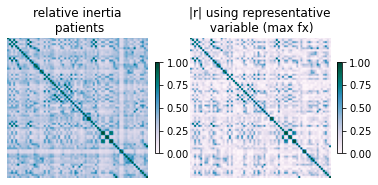

In [27]:
plt.subplot(1,2,1)
plt.title('relative inertia\n patients')
plt.imshow(P_Relative_inertias + P_Relative_inertias.T - np.eye(len(P_Relative_inertias)),'PuBuGn')
plt.axis('off')
plt.clim(0,1)
plt.colorbar(fraction = 0.03)
plt.subplot(1,2,2)
plt.title('|r| using representative\n variable (max fx)')
plt.imshow(np.abs(corrMatrixPat),'PuBuGn')
plt.axis('off')
plt.clim(0,1)
plt.colorbar(fraction = 0.03)

In [34]:
# 2) "Dissatenuated" relative inertias
# Same analysis as with the univariate distance correlations, i.e., we select the EEG feature with the strongest rel inertia (<1)
# and use it as an estimate of a reliability estimate and then use the same formula used for the correlations

con_data_ri = np.abs(np.round((C_Relative_inertias + C_Relative_inertias.T) - 2*np.eye(len(C_Relative_inertias)),2))
pat_data_ri = np.abs(np.round((P_Relative_inertias + P_Relative_inertias.T) - 2*np.eye(len(P_Relative_inertias)),2))

con_index_ri = []
con_value_ri = []

pat_index_ri = []
pat_value_ri = []

for k in range (len(con_data_ri)):
    
    c_index_ri, c_value_ri = max(enumerate(con_data_ri[k][np.where(con_data_ri[k]<0.99)[0]]), key=operator.itemgetter(1))
    c_index_ri = np.where(con_data_ri[k]==c_value_ri)[0][0]
    p_index_ri, p_value_ri = max(enumerate(pat_data_ri[k][np.where(pat_data_ri[k]<0.99)[0]]), key=operator.itemgetter(1))
    p_index_ri = np.where(pat_data_ri[k]==p_value_ri)[0][0]
    
    con_index_ri.append(c_index_ri)
    con_value_ri.append(c_value_ri)
    
    pat_index_ri.append(p_index_ri)
    pat_value_ri.append(p_value_ri)

con_dis_ri = np.zeros(con_data_ri.shape)
pat_dis_ri = np.zeros(pat_data_ri.shape)

for k in range (len(con_data_ri)):
    for j in range(len(con_data_ri)):
        con_dis_ri[k,j] = con_data_ri[k,j]/np.sqrt(con_value_ri[k]*con_value_ri[j])
        pat_dis_ri[k,j] = pat_data_ri[k,j]/np.sqrt(pat_value_ri[k]*pat_value_ri[j])
    

up_tri_ind = np.triu_indices(len(con_dis_ri), k = 1)  
print("Using disattenuated relative inertias using the same procedure as in univariate analysis")
print(f"disattenuated rel inertia percentiles 25,50,75 controls: {np.percentile(np.abs(con_dis_ri[up_tri_ind]),(25,50,75))}")
print(f"disattenuated rel inertia percentiles 25,50,75 patients: {np.percentile(np.abs(pat_dis_ri[up_tri_ind]),(25,50,75))}")


Using disattenuated relative inertias using the same procedure as in univariate analysis
disattenuated rel inertia percentiles 25,50,75 controls: [0.38008799 0.47883787 0.59976673]
disattenuated rel inertia percentiles 25,50,75 patients: [0.31327191 0.42574319 0.54852186]


In [35]:
# features used as reference for reliability using relative inertias
# controls
con_eeg_feats_ri = list(df_EEG_names.loc[corrMatrixCon.index]['new-names'])
con_max_corr_ri = list(df_EEG_names.loc[corrMatrixCon.index[con_index_ri]]['new-names'])
df_reliability_controls_ri = pd.DataFrame(data=np.vstack((np.array(con_max_corr_ri),np.array(con_value_ri))).transpose(),
                                          index=con_eeg_feats_ri,columns=['used as reference', 'relative inertia'])

# save features selected for reliability analysis in controls
df_reliability_controls_ri.to_csv("controls_estimate_reliability_relative_inertia.csv")

# patients
pat_eeg_feats_ri = list(df_EEG_names.loc[corrMatrixPat.index]['new-names'])
pat_max_corr_ri = list(df_EEG_names.loc[corrMatrixPat.index[pat_index_ri]]['new-names'])
df_reliability_patients_ri = pd.DataFrame(data=np.vstack((np.array(pat_max_corr_ri),np.array(pat_value_ri))).transpose(),
                                          index=pat_eeg_feats_ri,columns=['used as reference', 'relative inertia'])

# save features selected for reliability analysis in patients
df_reliability_patients_ri.to_csv("patients_estimate_reliability_relative_inertia.csv")
df_reliability_patients_ri

,used as reference,relative inertia
mod index alpha-gamma,mod index delta-gamma,0.6
mean ampl gamma,kfd gamma,0.91
mean ampl theta,kfd theta,0.97
std ampl gamma,kfd gamma,0.9
std ampl theta,kfd theta,0.97
...,...,...
spectral entropy gamma,kfd gamma,0.49
spectral entropy theta,skewness ampl theta,0.63
relative ampl theta,hfd alpha,0.7
waiting time beta,life time beta,0.86


In [31]:
# 3) Multivariate distance correlation analysis

# First run R code named 02_Multivariate_distance_correlations_multiverse.ipynb
# Uses the function dcorT from the package -> https://cran.r-project.org/web/packages/energy/energy.pdf
# load data from multivariate distance correlation (t test) analysis
# Data from patients
# magnitudes
mvdc_magn_pat = pd.read_csv("5_dc_fx_pat.csv", index_col = 0)
# pvalues
mvdc_pvals_pat = pd.read_csv("5_dc_pval_pat.csv", index_col = 0)

# Data from controls
# magnitudes
mvdc_magn_con = pd.read_csv("5_dc_fx_controls.csv", index_col = 0)
# pvalues
mvdc_pvals_con = pd.read_csv("5_dc_pval_controls.csv", index_col = 0)


mvdc_significant_pat = mvdc_magn_pat[df_Big_Diff.columns[sig_p_vals]].loc[df_Big_Diff.columns[sig_p_vals]]
mvdc_significantpv_pat = mvdc_pvals_pat[df_Big_Diff.columns[sig_p_vals]].loc[df_Big_Diff.columns[sig_p_vals]]

mvdc_significant_con = mvdc_magn_con[df_Big_Diff.columns[sig_p_vals]].loc[df_Big_Diff.columns[sig_p_vals]]
mvdc_significantpv_con = mvdc_pvals_con[df_Big_Diff.columns[sig_p_vals]].loc[df_Big_Diff.columns[sig_p_vals]]

up_tri_ind = np.triu_indices(len(mvdc_significant_pat), k = 1)           

print("Using multivariate distance correlation between the EEG features showing a significant group difference")
print(f"dc percentiles 25,50,75 controls: {np.percentile(np.abs(mvdc_significant_con.values[up_tri_ind]),(25,50,75))}")
print(f"dc percentiles 25,50,75 patients: {np.percentile(np.abs(mvdc_significant_pat.values[up_tri_ind]),(25,50,75))}")
print(f"sqrt dc percentiles 25,50,75 controls: {np.sqrt(np.percentile(np.abs(mvdc_significant_con.values[up_tri_ind]),(25,50,75)))}")
print(f"sqrt dc percentiles 25,50,75 patients: {np.sqrt(np.percentile(np.abs(mvdc_significant_pat.values[up_tri_ind]),(25,50,75)))}")
print(f"% of significant multivariate distance correlations in controls:{len(np.where(mvdc_significantpv_con.values[up_tri_ind]<0.05)[0])/len(up_tri_ind[0])}")
print(f"% of significant multivariate distance correlations in patients:{len(np.where(mvdc_significantpv_pat.values[up_tri_ind]<0.05)[0])/len(up_tri_ind[0])}")

up_tri_ind = np.triu_indices(len(mvdc_magn_pat), k = 1) 

print("\n")
print("Using multivariate distance correlation between all EEG features")
print(f"dc percentiles 25,50,75 controls: {np.percentile(np.abs(mvdc_magn_con.values[up_tri_ind]),(25,50,75))}")
print(f"dc percentiles 25,50,75 patients: {np.percentile(np.abs(mvdc_magn_pat.values[up_tri_ind]),(25,50,75))}")
print(f"sqrt dc percentiles 25,50,75 controls: {np.sqrt(np.percentile(np.abs(mvdc_magn_con.values[up_tri_ind]),(25,50,75)))}")
print(f"sqrt dc percentiles 25,50,75 patients: {np.sqrt(np.percentile(np.abs(mvdc_magn_pat.values[up_tri_ind]),(25,50,75)))}")
print(f"% of significant multivariate distance correlations in controls:{len(np.where(mvdc_pvals_con.values[up_tri_ind]<0.05)[0])/len(up_tri_ind[0])}")
print(f"% of significant multivariate distance correlations in patients:{len(np.where(mvdc_pvals_pat.values[up_tri_ind]<0.05)[0])/len(up_tri_ind[0])}")

Using multivariate distance correlation between the EEG features showing a significant group difference
dc percentiles 25,50,75 controls: [0.01049831 0.02819758 0.09175981]
dc percentiles 25,50,75 patients: [0.0092139  0.03567689 0.10855532]
sqrt dc percentiles 25,50,75 controls: [0.10246128 0.16792136 0.30291882]
sqrt dc percentiles 25,50,75 patients: [0.09598906 0.18888326 0.32947735]
% of significant multivariate distance correlations in controls:0.4701619778346121
% of significant multivariate distance correlations in patients:0.6159420289855072


Using multivariate distance correlation between all EEG features
dc percentiles 25,50,75 controls: [0.01125218 0.0313872  0.10004724]
dc percentiles 25,50,75 patients: [0.00836071 0.02576446 0.07974259]
sqrt dc percentiles 25,50,75 controls: [0.10607631 0.17716433 0.31630244]
sqrt dc percentiles 25,50,75 patients: [0.09143693 0.1605131  0.2823873 ]
% of significant multivariate distance correlations in controls:0.4947385289247369
% of sig

In [35]:
# save data for meta corr
mvdc_significant_pat.to_csv("meta_6_patients.csv")
mvdc_significantpv_pat.to_csv("meta_6_patients_pvalues.csv")
mvdc_significant_con.to_csv("meta_6_controls.csv")
mvdc_significantpv_con.to_csv("meta_6_controls_pvalues.csv")

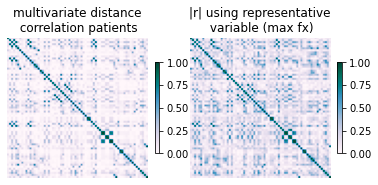

In [36]:
plt.subplot(1,2,1)
plt.title('multivariate distance\n correlation patients')
plt.imshow(mvdc_significant_pat + mvdc_significant_pat.T - np.eye(len(mvdc_significant_pat)),'PuBuGn')
plt.axis('off')
plt.clim(0,1)
plt.colorbar(fraction = 0.03)
plt.subplot(1,2,2)
plt.title('|r| using representative\n variable (max fx)')
plt.imshow(np.abs(corrMatrixPat),'PuBuGn')
plt.axis('off')
plt.clim(0,1)
plt.colorbar(fraction = 0.03)

In [38]:
# 3) "Dissatenuated" multivariate distance correlations
# Same analysis as with the univariate distance correlations, i.e., we select the EEG feature with the strongest rel inertia (<1)
# and use it as an estimate of a reliability estimate and then use the same formula used for the correlations

con_data_dc = np.abs(np.round((mvdc_significant_con.values + mvdc_significant_con.values.T) - 2*np.eye(len(mvdc_significant_con.values)),2))
pat_data_dc = np.abs(np.round((mvdc_significant_pat.values + mvdc_significant_pat.values.T) - 2*np.eye(len(mvdc_significant_pat.values)),2))

con_index_dc = []
con_value_dc = []

pat_index_dc = []
pat_value_dc = []

for k in range (len(con_data_dc)):
    
    c_index_dc, c_value_dc = max(enumerate(con_data_dc[k][np.where(con_data_dc[k]<0.99)[0]]), key=operator.itemgetter(1))
    c_index_dc = np.where(con_data_dc[k]==c_value_dc)[0][0]
    p_index_dc, p_value_dc = max(enumerate(pat_data_dc[k][np.where(pat_data_dc[k]<0.99)[0]]), key=operator.itemgetter(1))
    p_index_dc = np.where(pat_data_dc[k]==p_value_dc)[0][0]
    
    con_index_dc.append(c_index_dc)
    con_value_dc.append(c_value_dc)
    
    pat_index_dc.append(p_index_dc)
    pat_value_dc.append(p_value_dc)

con_dis_dc = np.zeros(con_data_dc.shape)
pat_dis_dc = np.zeros(pat_data_dc.shape)

for k in range (len(con_data_dc)):
    for j in range(len(con_data_dc)):
        con_dis_dc[k,j] = con_data_dc[k,j]/np.sqrt(con_value_dc[k]*con_value_dc[j])
        pat_dis_dc[k,j] = pat_data_dc[k,j]/np.sqrt(pat_value_dc[k]*pat_value_dc[j])
    

up_tri_ind = np.triu_indices(len(con_dis_ri), k = 1)  
print("Using disattenuated distance correlations using the same procedure as in univariate analysis")
print(f"disattenuated distance correlations percentiles 25,50,75 controls: {np.percentile(np.abs(con_dis_dc[up_tri_ind]),(25,50,75))}")
print(f"disattenuated distance correlations percentiles 25,50,75 patients: {np.percentile(np.abs(pat_dis_dc[up_tri_ind]),(25,50,75))}")
print(f"sqrt disattenuated distance correlations percentiles 25,50,75 controls: {np.sqrt(np.percentile(np.abs(con_dis_dc[up_tri_ind]),(25,50,75)))}")
print(f"sqrt disattenuated distance correlations percentiles 25,50,75 patients: {np.sqrt(np.percentile(np.abs(pat_dis_dc[up_tri_ind]),(25,50,75)))}")


Using disattenuated distance correlations using the same procedure as in univariate analysis
disattenuated distance correlations percentiles 25,50,75 controls: [0.01600616 0.05077456 0.14563922]
disattenuated distance correlations percentiles 25,50,75 patients: [0.01757839 0.06225728 0.19198055]
sqrt disattenuated distance correlations percentiles 25,50,75 controls: [0.12651544 0.22533211 0.38162707]
sqrt disattenuated distance correlations percentiles 25,50,75 patients: [0.13258351 0.24951409 0.43815585]


In [39]:
# features used as reference for reliability using distance correlations
# controls
con_eeg_feats_dc = list(df_EEG_names.loc[corrMatrixCon.index]['new-names'])
con_max_corr_dc = list(df_EEG_names.loc[corrMatrixCon.index[con_index_dc]]['new-names'])
df_reliability_controls_dc = pd.DataFrame(data=np.vstack((np.array(con_max_corr_dc),np.array(con_value_dc))).transpose(),
                                          index=con_eeg_feats_dc,columns=['used as reference', 'mv dc'])

# save features selected for reliability analysis in controls
df_reliability_controls_dc.to_csv("controls_estimate_reliability_distance_correlations.csv")

# patients
pat_eeg_feats_dc = list(df_EEG_names.loc[corrMatrixPat.index]['new-names'])
pat_max_corr_dc = list(df_EEG_names.loc[corrMatrixPat.index[pat_index_dc]]['new-names'])
df_reliability_patients_dc = pd.DataFrame(data=np.vstack((np.array(pat_max_corr_dc),np.array(pat_value_dc))).transpose(),
                                          index=pat_eeg_feats_dc,columns=['used as reference', 'mv dc'])

# save features selected for reliability analysis in patients
df_reliability_patients_dc.to_csv("patients_estimate_reliability_distance_correlations.csv")
df_reliability_patients_dc

,used as reference,mv dc
mod index alpha-gamma,mod index delta-gamma,0.32
mean ampl gamma,std ampl gamma,0.98
mean ampl theta,kfd theta,0.96
std ampl gamma,mean ampl gamma,0.98
std ampl theta,kfd theta,0.95
...,...,...
spectral entropy gamma,kfd gamma,0.31
spectral entropy theta,skewness ampl theta,0.55
relative ampl theta,hfd alpha,0.51
waiting time beta,life time beta,0.73
